<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/model_training.ipynb)


This is a version of the notebook from [Matthew Carrigan](https://huggingface.co/Rocketknight1) --- [here](https://huggingface.co/blog/deep-learning-with-proteins).

In [ ]:
!pip install "transformers[torch]" datasets evaluate
!pip install transformers

*NOTE*: If you're opening this notebook locally, make sure your environment has installed these libraries as well:
```shell
!pip install jupyter ipywidgets --upgrade
!pip install pandas scikit-learn
```

<h3><span style="color:red">Important</span></h3> 
If you are running in Google Colab, change the Notebook settings to use `GPU`.

Just follow **Edit** > **Notebook settings** or **Runtime** > **Change runtime type** and select **GPU** as Hardware accelerator.

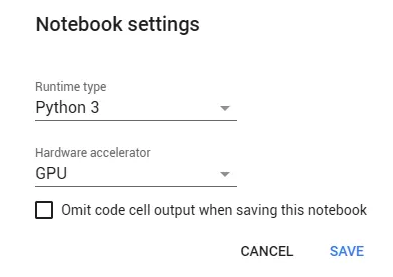


# Fine-Tuning Protein Language Models

In this notebook, we are going to use transfer learning to fine-tune a large, pre-trained protein language model to predict **Subcellular location** based on protein sequence. 

The specific model we are going to use is [ESM](https://github.com/facebookresearch/esm), which is the state-of-the-art protein language model at the time of writing (November 2022) and described in detail in [Lin et al, 2022](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1).

There are several ESM-2 checkpoints with differing model sizes. **A checkpoint** is an intermediate dump of a model’s entire internal state (weights, learning rate, etc.) so that the framework can resume the training from this point whenever desired. 

Larger models will generally have better accuracy, but they require more GPU memory and will take much longer to train. The available ESM-2 checkpoints are:

| Checkpoint name | Num layers | Num parameters |
|------------------------------|----|----------|
| `esm2_t48_15B_UR50D`         | 48 | 15B     |
| `esm2_t36_3B_UR50D`          | 36 | 3B      |
| `esm2_t33_650M_UR50D`        | 33 | 650M    |
| `esm2_t30_150M_UR50D`        | 30 | 150M    |
| `esm2_t12_35M_UR50D`         | 12 | 35M     |
| `esm2_t6_8M_UR50D`           | 6  | 8M      |

*Note*: larger checkpoints may be very difficult to train without a large cloud GPU like an A100 or H100, and the largest 15B parameter checkpoint will probably be impossible to train on **any** single GPU! Also, note that memory usage for attention during training will scale as `O(batch_size * num_layers * seq_len^2)`, so larger models on long sequences will use quite a lot of memory! We will use the `esm2_t12_35M_UR50D` checkpoint for this notebook, which should train on any Colab instance or modern GPU.

In [ ]:
model_checkpoint = "facebook/esm2_t12_35M_UR50D"

# Fine-tuning

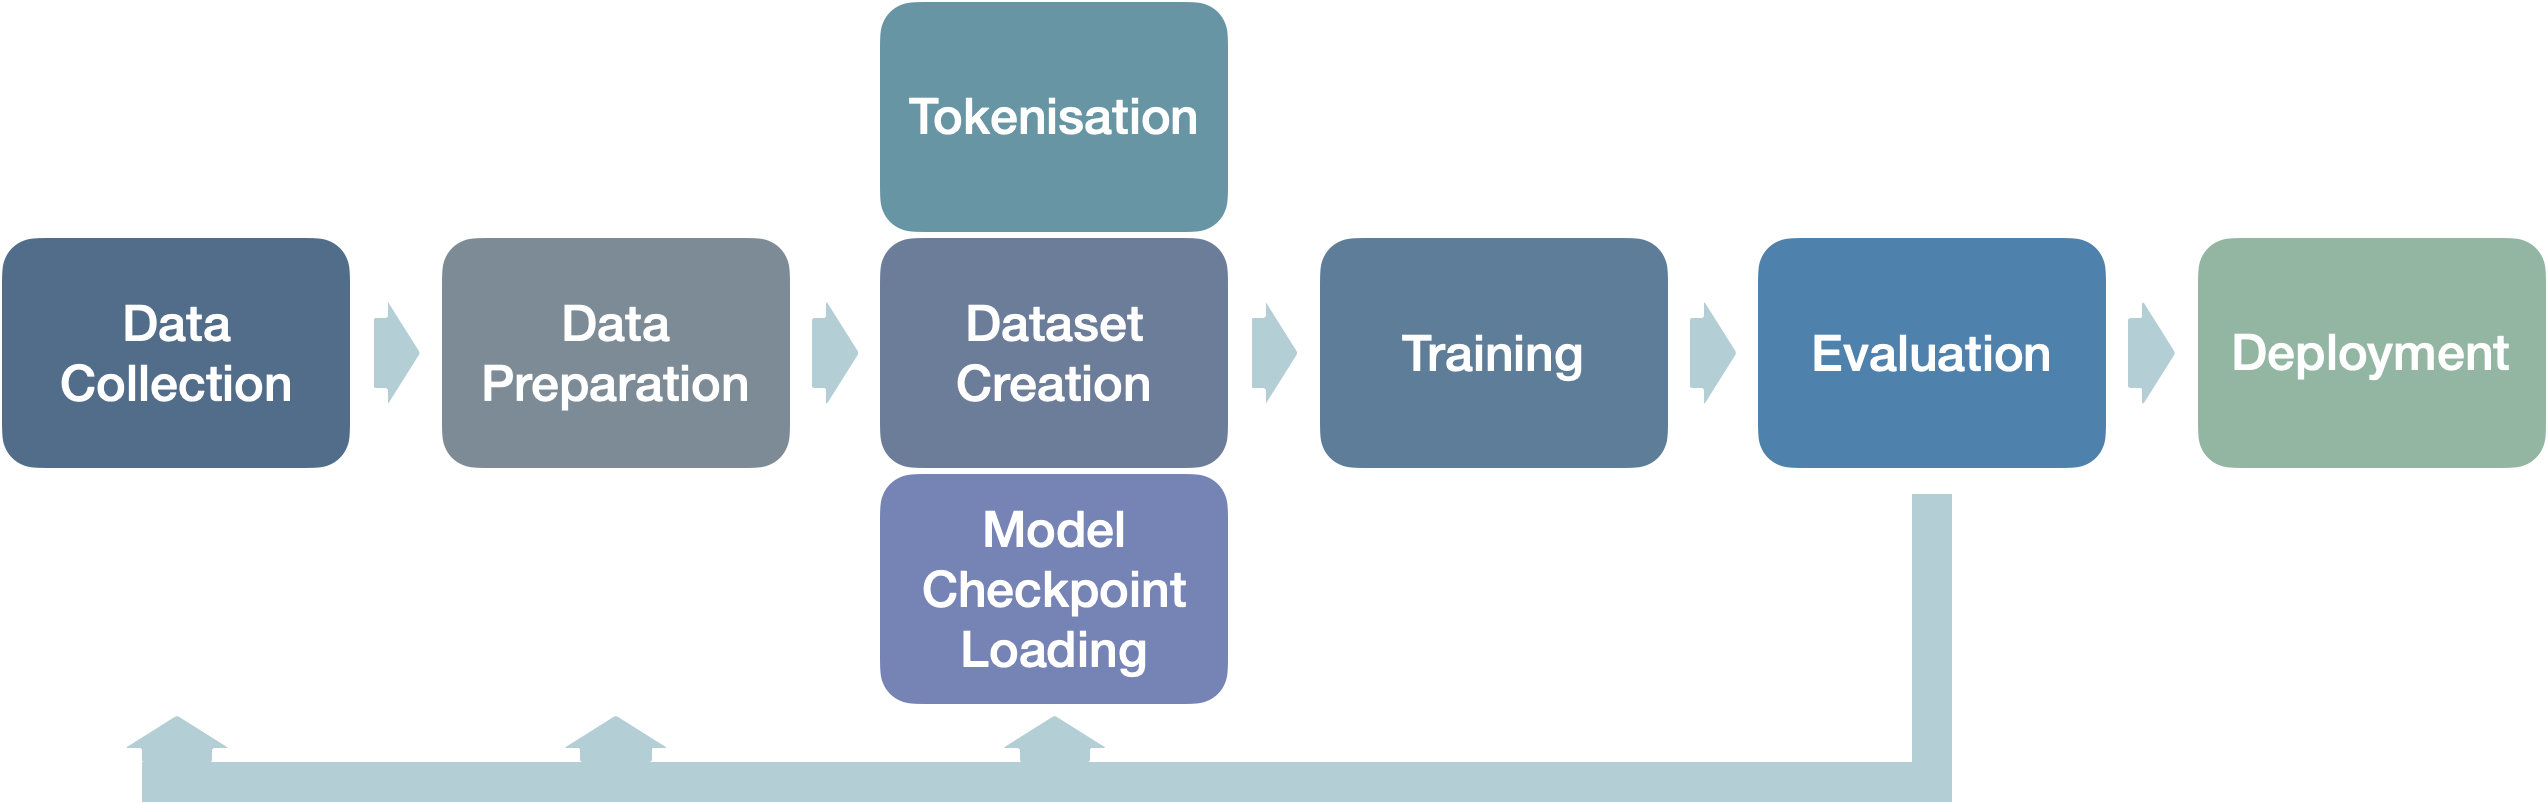

## Subcellular Location

## Data Collection

We will gather data from [UniProt](https://www.uniprot.org/) to create a pair of lists: `sequences` and `labels`. `sequences` will be a list of protein sequences and `labels` will be a list of the category for each sequence (integers).

In [ ]:
import requests
import urllib.parse

organism = 9606
fields = ",".join(['accession', 'sequence', 'cc_subcellular_location'])
query = f'((organism_id:{organism}) AND (reviewed:true) AND (length:[80 TO 500]))'
params = {
    'compressed': 'true', 
    'fields': fields, 
    'format':'tsv', 
    'query':query
}
query_url = 'https://rest.uniprot.org/uniprotkb/stream?'
query_url += urllib.parse.urlencode(params)

# take a look 
print(query_url)

We searched for `(organism_id:9606) AND (reviewed:true) AND (length:[80 TO 500])` on UniProt to get a list of reasonably-sized human proteins, then selected the format to TSV and the columns to `Accession`, `Sequence` and `Subcellular location [CC]`, since those contain the data we care about for this task.

In [ ]:
uniprot_request = requests.get(query_url)

To get this data into Pandas, we use a `BytesIO` object, which Pandas will treat like a file. If you downloaded the data as a file you can skip this bit and just pass the filepath directly to `read_csv`.

In [ ]:
from io import BytesIO
import pandas as pd

# read in content to dataframe
bio = BytesIO(uniprot_request.content)
df = pd.read_csv(bio, compression='gzip', sep='\t')

# check out first 5 rows of df
df.head()

In [ ]:
# learn more about the df via .info() or .shape
df.info()

Nice! Now we have some proteins and their subcellular locations. Let's start filtering this down. First, let's ditch the columns without subcellular location information.

## Data Preparation

In [ ]:
# Drop proteins with missing columns
df = df.dropna() 

In [ ]:
# check
df.info()

Now we'll make one dataframe of proteins that contain `cytosol` or `cytoplasm` in their subcellular localization column, and a second that mentions the `membrane` or `cell membrane`.

In [ ]:
# first creating boolean series
cytosolic = df['Subcellular location [CC]'].str.contains("Cytosol") | df['Subcellular location [CC]'].str.contains("Cytoplasm")
membrane = df['Subcellular location [CC]'].str.contains("Membrane") | df['Subcellular location [CC]'].str.contains("Cell membrane")

We ensure that there is no overlap between classes.

In [ ]:
# use above booleans to filter df
# NOTE: using .copy() when slicing/filtering an existing dataframe 
#       prevents the triggering of 'SettingWithCopyWarning' 
cytosolic_df = df[cytosolic & ~membrane].copy()

# check using .head() and/or .tail()
cytosolic_df.head()

In [ ]:
cytosolic_df.tail()

In [ ]:
# use boolean series to filter df
membrane_df = df[membrane & ~cytosolic].copy()

# check
membrane_df.head()

In [ ]:
membrane_df.tail()

Now, let's add labels. We use `0` as the label for cytosolic proteins and `1` as the label for membrane proteins.

In [ ]:
# adding label columns
cytosolic_df['label'] = 0
membrane_df['label'] = 1

Now we will combine the 2 groups to form our initial dataset. Don't worry - the proteins will get shuffled when splitting the data!

In [ ]:
# combining dataframes and only keeping 'Sequence' and 'label' columns
df_sequences = pd.concat([cytosolic_df, membrane_df])[['Sequence', 'label']]

# check
df_sequences.info()

In [ ]:
# check class distribution
df_sequences['label'].value_counts(normalize=True)

We can also see that we will be working with a dataset with a balanced number of observations per class. 

### Splitting the data

We need to split the data into train and test sets. We can use sklearn's function for that:

In [ ]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    df_sequences['Sequence'], 
    df_sequences['label'],
    test_size=0.2,
    shuffle=True, #default
    stratify=df_sequences['label']
)

In [ ]:
!pip install biopython

### Quick EDA of the datasets

In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# recall this function from seq_analysis.ipynb
# calculates mean amino acid composition for a set of sequences
def calculate_mean_AA_composition(sequences):
    stats = []
    for sequence in sequences:
        protein_sequence = ProteinAnalysis(sequence)
        st = {k:v/len(sequence) for k,v in protein_sequence.count_amino_acids().items()}
        stats.append(st)
    df = pd.DataFrame.from_dict(stats).transpose()
    df = df.T.mean().reset_index()
    df.columns = ['amino acid', 'mean']

    return df

In [ ]:
train_df = calculate_mean_AA_composition(train_sequences)
test_df = calculate_mean_AA_composition(test_sequences)

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'

fig = px.bar(train_df.sort_values(by='mean'), x='amino acid', y='mean', color='mean')
fig.show()

In [ ]:
fig = px.bar(test_df.sort_values('mean'), x='amino acid', y='mean', color='mean')
fig.show()

## Tokenisation

All inputs to neural nets must be numerical. The process of converting strings into numerical indices suitable for a neural net is called **tokenization**. For natural language this can be quite complex, as usually the network's vocabulary will not contain every possible word, which means the tokenizer must handle splitting rarer words into pieces, as well as all the complexities of capitalization and unicode characters and so on.

With proteins, however, things are very easy. In protein language models, each amino acid is converted to a single token. Every model on `transformers` comes with an associated `tokenizer` that handles tokenization for it, and protein language models are no different. Let's get our tokenizer!

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Let's try a single sequence to see what the outputs from our tokenizer look like:

In [ ]:
tokenizer(train_sequences[0])

This looks good! We can see that our sequence has been converted into `input_ids`, which is the tokenized sequence, and an `attention_mask`. The attention mask handles the case when we have sequences of variable length - in those cases, the shorter sequences are padded with blank "padding" tokens, and the attention mask is padded with 0s to indicate that those tokens should be ignored by the model.

So now, let's tokenize our whole dataset. Note that we don't need to do anything with the labels, as they're already in the format we need.

In [ ]:
# tokenize train and test sequences, which need to be list of str
train_tokenized = tokenizer(train_sequences.tolist())
test_tokenized = tokenizer(test_sequences.tolist())

## Training Dataset creation

Now we want to turn this data into a dataset that PyTorch can load samples from. We can use the HuggingFace `Dataset` class for this, although if you prefer you can also use `torch.utils.data.Dataset`, at the cost of some more boilerplate code.

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# check
train_dataset

This looks good, but we're missing our labels! Let's add those on as an extra column to the datasets.

In [ ]:
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

# check
train_dataset

We will split the training set further to use a subset of the data to evaluate the model during fine-tuning (i.e., validation dataset).

In [ ]:
train_val_dataset = train_dataset.train_test_split(test_size=0.2)

# check
train_val_dataset

Looks good! We're ready for training.

## Model loading

Next, we want to load our model. Make sure to use exactly the same model as you used when loading the tokenizer, or your model might not understand the tokenization scheme you're using!

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# the number of classes 
num_labels = train_labels.nunique() #2 

# instantiate the model
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

These warnings are telling us that the model is discarding some weights that it used for language modelling (the `lm_head`) and adding some weights for sequence classification (the `classifier`). This is exactly what we expect when we want to fine-tune a language model on a sequence classification task!

Next, we initialize our `TrainingArguments`. These control the various training hyperparameters, and will be passed to our `Trainer`.

In [ ]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization",
    evaluation_strategy = "epoch", #evaluate at end of every epoch
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    optim="adamw_torch",
)

Next, we define the metric we will use to evaluate our models and write a `compute_metrics` function. We can load this from the `evaluate` library.

In [ ]:
from evaluate import load
import numpy as np

# we will compute the model accuracy
metric = load("accuracy")

# build evaluation function to be used during model training
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Training

And at last we're ready to initialize our `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_val_dataset['train'],
    eval_dataset=train_val_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it one last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

Nice! After three epochs we have a model accuracy of ~94%. 

## Evaluation

We will take a look at how our final fine-tuned model performs when predicting the subcellular location of protein sequences the model has not seen before (i.e., test set).

In [ ]:
# taking a look at model outputs
output = trainer.predict(test_dataset)

In [ ]:
# from logits to classifications

from scipy.special import softmax

# from logits to class probabilities
y_proba = softmax(output.predictions, axis=-1)

# from probabilities to classifications
y_pred = np.argmax(y_proba, axis=-1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_labels, y_pred=y_pred))

Our goal was to classify the subcellular location of given proteins. Our final fine-tuned model achieved 95% on the test set. Note that we didn't do a lot of work to filter the training data or tune hyperparameters for this experiment, and also that we used one of the smallest ESM-2 models. With a larger starting model and more effort to ensure that the training data categories were cleanly separable, accuracy could almost certainly go a lot higher!